## Real Life example

Below is actually a very basic example from my own research. This is an epidemiological model of the first 70 days of the COVID-19 pandemic starting from the beginning of March until the end of May and is a good illustration of how summary statistic can influence the inference results.

We will implement a version of SEIR model (Susceptible-Exposed-Infected-Recovered) and will use `pyross` package for that

We do the necessary imports first

In [1]:
import time
import torch
import sbi.utils as utils
from sbi.inference.base import infer
from sbi.analysis.plot import pairplot
import numpy as np

import pyross
from matplotlib import pyplot as plt
from datetime import date
import pandas as pd
import multiprocessing
from sbi.inference import SNPE, SNRE, prepare_for_sbi, simulate_for_sbi
import os 

/p/software/jusuf/stages/2024/software/tqdm/4.66.1-GCCcore-12.3.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-27 23:10:57,756	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Data pre-processing

To avoid importing complex epidemiological packages we will only define certain classes of objects important for our particular task. The class below is a snippet from `memilio` package, which is a software useful for epidemics simulation (https://github.com/SciCompMod/memilio/tree/main)

In [2]:
import logging
import time
from datetime import date, timedelta
from enum import Enum
from pathlib import Path
from typing import List, Mapping




class CaseData:
    class Label(str, Enum):
        DATE = "Date"
        CONFIRMED = "Confirmed"
        RECOVERED = "Recovered"
        DEATHS = "Deaths"

    def __init__(self, data: pd.DataFrame):
        self.data = data

    def __eq__(self, other):
        if isinstance(other, self.__class__):
            return (self.data == other.data).all().all()
        else:
            return False

    def to_oseir_compartments(self, time_exposed, time_infected) -> pd.DataFrame:
        case_data = self.data.copy()

        # round time_exposed for now
        case_data["COMPARTMENT_EXPOSED"] = -case_data[self.Label.CONFIRMED.value].diff(
            periods=-int(time_exposed)
        )
        case_data["COMPARTMENT_INFECTED"] = case_data[self.Label.CONFIRMED.value].diff(
            periods=int(time_infected)
        )
        # Deaths are counted as recovered, because oseir is a test-model without deaths compartment.
        case_data["COMPARTMENT_RECOVERED"] = (
            case_data[self.Label.RECOVERED.value] + case_data[self.Label.DEATHS.value]
        )

        # num_susceptible is not set here, because memilio-models have a function for that

        case_data.drop(
            columns=[
                c
                for c in case_data.columns
                if c
                not in [
                    self.Label.DATE.value,
                    "COMPARTMENT_EXPOSED",
                    "COMPARTMENT_INFECTED",
                    "COMPARTMENT_RECOVERED",
                ]
            ],
            inplace=True,
        )
        return case_data

    def to_pyross_oseir_array(self, total_population, time_exposed, time_infected) -> np.array:
        """This function computes compartments based on case data. It will produce some nans at the beginning and end
        of array because some compartments can not be estimated"""
        dataframe = self.to_oseir_compartments(time_exposed, time_infected)
        print(dataframe.columns)
        dataframe["COMPARTMENT_SUSCEPTIBLE"] = (
            total_population
            - dataframe["COMPARTMENT_EXPOSED"]
            - dataframe["COMPARTMENT_INFECTED"]
            - dataframe["COMPARTMENT_RECOVERED"]
        )
        dataframe = dataframe[
            [
                "COMPARTMENT_SUSCEPTIBLE",
                "COMPARTMENT_EXPOSED",
                "COMPARTMENT_INFECTED",
                "COMPARTMENT_RECOVERED",
            ]
        ]
        return dataframe.to_numpy()

    @staticmethod
    def read_json_from_dir(data_dir: Path, keys: List[str] = None) -> "CaseData":
        case_data = {}
        if keys is None:
            _keys = [file for file in Path.iterdir(data_dir) if file.suffix == ".json"]
        else:
            _keys = [data_dir / Path(key + ".json") for key in keys]

        for key in _keys:
            case_data[Path(key).stem] = CaseData(pd.read_json(key))

        return case_data

## RKI data

Again, not to overload our example with additional RKI software we pass the pre-downloaded RKI data on the incidence rates as a dicitonary. Further on, we pass it to the class `CaseData` defined above and get the input ready for SBI implementation.

In [3]:
data={"Date":"2020-03-01","Confirmed":1902.4285714286,"Deaths":43.0,"Recovered":1859.4285714286},{"Date":"2020-03-02","Confirmed":2206.5714285714,"Deaths":50.1428571429,"Recovered":2156.4285714286},{"Date":"2020-03-03","Confirmed":2575.8571428571,"Deaths":59.4285714286,"Recovered":2516.4285714286},{"Date":"2020-03-04","Confirmed":3034.7142857143,"Deaths":71.5714285714,"Recovered":2963.1428571429},{"Date":"2020-03-05","Confirmed":3619.0,"Deaths":86.2857142857,"Recovered":3532.7142857143},{"Date":"2020-03-06","Confirmed":4415.0,"Deaths":103.2857142857,"Recovered":4311.7142857143},{"Date":"2020-03-07","Confirmed":5491.0,"Deaths":123.7142857143,"Recovered":5367.2857142857},{"Date":"2020-03-08","Confirmed":6912.8571428571,"Deaths":149.5714285714,"Recovered":6763.2857142857},{"Date":"2020-03-09","Confirmed":8721.5714285714,"Deaths":182.7142857143,"Recovered":8538.8571428571},{"Date":"2020-03-10","Confirmed":10993.8571428571,"Deaths":224.4285714286,"Recovered":10769.4285714286},{"Date":"2020-03-11","Confirmed":13707.5714285714,"Deaths":271.7142857143,"Recovered":13435.8571428571},{"Date":"2020-03-12","Confirmed":16841.2857142857,"Deaths":329.7142857143,"Recovered":16511.5714285714},{"Date":"2020-03-13","Confirmed":20505.1428571429,"Deaths":403.5714285714,"Recovered":20101.5714285714},{"Date":"2020-03-14","Confirmed":24549.1428571429,"Deaths":490.7142857143,"Recovered":24058.4285714286},{"Date":"2020-03-15","Confirmed":28924.0,"Deaths":591.7142857143,"Recovered":28332.2857142857},{"Date":"2020-03-16","Confirmed":33503.2857142857,"Deaths":702.4285714286,"Recovered":32800.8571428571},{"Date":"2020-03-17","Confirmed":38265.8571428571,"Deaths":830.0,"Recovered":37435.8571428571},{"Date":"2020-03-18","Confirmed":43075.4285714286,"Deaths":969.4285714286,"Recovered":42106.0},{"Date":"2020-03-19","Confirmed":47794.4285714286,"Deaths":1113.4285714286,"Recovered":46681.0},{"Date":"2020-03-20","Confirmed":52439.8571428571,"Deaths":1274.5714285714,"Recovered":51165.2857142857},{"Date":"2020-03-21","Confirmed":56958.7142857143,"Deaths":1447.8571428571,"Recovered":55510.8571428571},{"Date":"2020-03-22","Confirmed":61394.1428571429,"Deaths":1637.2857142857,"Recovered":59756.8571428571},{"Date":"2020-03-23","Confirmed":65782.7142857143,"Deaths":1841.1428571429,"Recovered":63941.5714285714},{"Date":"2020-03-24","Confirmed":70062.2857142857,"Deaths":2053.7142857143,"Recovered":68008.5714285714},{"Date":"2020-03-25","Confirmed":74301.5714285714,"Deaths":2283.5714285714,"Recovered":72018.0},{"Date":"2020-03-26","Confirmed":78484.7142857143,"Deaths":2520.2857142857,"Recovered":75964.4285714286},{"Date":"2020-03-27","Confirmed":82580.5714285714,"Deaths":2765.2857142857,"Recovered":79815.2857142857},{"Date":"2020-03-28","Confirmed":86664.7142857143,"Deaths":3018.1428571429,"Recovered":83646.5714285714},{"Date":"2020-03-29","Confirmed":90732.2857142857,"Deaths":3278.5714285714,"Recovered":87453.7142857143},{"Date":"2020-03-30","Confirmed":94794.8571428571,"Deaths":3553.1428571429,"Recovered":91241.7142857143},{"Date":"2020-03-31","Confirmed":98846.7142857143,"Deaths":3839.8571428571,"Recovered":95006.8571428571},{"Date":"2020-04-01","Confirmed":102799.7142857143,"Deaths":4122.1428571429,"Recovered":98677.5714285714},{"Date":"2020-04-02","Confirmed":106698.2857142857,"Deaths":4408.0,"Recovered":102290.2857142857},{"Date":"2020-04-03","Confirmed":110474.4285714286,"Deaths":4691.4285714286,"Recovered":105783.0},{"Date":"2020-04-04","Confirmed":114176.8571428571,"Deaths":4974.0,"Recovered":109202.8571428571},{"Date":"2020-04-05","Confirmed":117736.4285714286,"Deaths":5251.4285714286,"Recovered":112485.0},{"Date":"2020-04-06","Confirmed":121161.0,"Deaths":5518.1428571429,"Recovered":115642.8571428571},{"Date":"2020-04-07","Confirmed":124328.4285714286,"Deaths":5764.4285714286,"Recovered":118564.0},{"Date":"2020-04-08","Confirmed":127361.8571428571,"Deaths":6001.2857142857,"Recovered":121360.5714285714},{"Date":"2020-04-09","Confirmed":130289.5714285714,"Deaths":6231.5714285714,"Recovered":124058.0},{"Date":"2020-04-10","Confirmed":132971.4285714286,"Deaths":6437.5714285714,"Recovered":126533.8571428571},{"Date":"2020-04-11","Confirmed":135455.4285714286,"Deaths":6628.2857142857,"Recovered":128827.1428571429},{"Date":"2020-04-12","Confirmed":137765.8571428571,"Deaths":6803.0,"Recovered":130962.8571428571},{"Date":"2020-04-13","Confirmed":139913.7142857143,"Deaths":6960.0,"Recovered":132953.7142857143},{"Date":"2020-04-14","Confirmed":142007.2857142857,"Deaths":7106.8571428571,"Recovered":134900.4285714286},{"Date":"2020-04-15","Confirmed":144005.5714285714,"Deaths":7244.0,"Recovered":136761.5714285714},{"Date":"2020-04-16","Confirmed":145917.4285714286,"Deaths":7373.4285714286,"Recovered":138544.0},{"Date":"2020-04-17","Confirmed":147805.8571428571,"Deaths":7502.1428571429,"Recovered":140303.7142857143},{"Date":"2020-04-18","Confirmed":149615.8571428571,"Deaths":7623.1428571429,"Recovered":141992.7142857143},{"Date":"2020-04-19","Confirmed":151349.8571428571,"Deaths":7734.2857142857,"Recovered":143615.5714285714},{"Date":"2020-04-20","Confirmed":153001.4285714286,"Deaths":7841.2857142857,"Recovered":145160.1428571429},{"Date":"2020-04-21","Confirmed":154548.2857142857,"Deaths":7939.5714285714,"Recovered":146608.7142857143},{"Date":"2020-04-22","Confirmed":156019.4285714286,"Deaths":8032.2857142857,"Recovered":147987.1428571429},{"Date":"2020-04-23","Confirmed":157418.1428571429,"Deaths":8115.5714285714,"Recovered":149302.5714285714},{"Date":"2020-04-24","Confirmed":158752.5714285714,"Deaths":8190.7142857143,"Recovered":150561.8571428571},{"Date":"2020-04-25","Confirmed":160025.1428571429,"Deaths":8260.7142857143,"Recovered":151764.4285714286},{"Date":"2020-04-26","Confirmed":161209.7142857143,"Deaths":8326.0,"Recovered":152883.7142857143},{"Date":"2020-04-27","Confirmed":162332.1428571429,"Deaths":8385.4285714286,"Recovered":153946.7142857143},{"Date":"2020-04-28","Confirmed":163370.7142857143,"Deaths":8440.4285714286,"Recovered":154930.2857142857},{"Date":"2020-04-29","Confirmed":164347.0,"Deaths":8490.1428571429,"Recovered":155856.8571428571},{"Date":"2020-04-30","Confirmed":165294.5714285714,"Deaths":8538.1428571429,"Recovered":156756.4285714286},{"Date":"2020-05-01","Confirmed":166193.4285714286,"Deaths":8582.8571428571,"Recovered":157610.5714285714},{"Date":"2020-05-02","Confirmed":167065.8571428571,"Deaths":8623.7142857143,"Recovered":158442.1428571429},{"Date":"2020-05-03","Confirmed":167913.1428571429,"Deaths":8659.5714285714,"Recovered":159253.5714285714},{"Date":"2020-05-04","Confirmed":168719.1428571429,"Deaths":8692.1428571429,"Recovered":160027.0},{"Date":"2020-05-05","Confirmed":169516.0,"Deaths":8724.2857142857,"Recovered":160791.7142857143},{"Date":"2020-05-06","Confirmed":170300.7142857143,"Deaths":8754.0,"Recovered":161546.7142857143},{"Date":"2020-05-07","Confirmed":171064.4285714286,"Deaths":8783.8571428571,"Recovered":162280.5714285714},{"Date":"2020-05-08","Confirmed":171806.7142857143,"Deaths":8810.7142857143,"Recovered":162996.0},{"Date":"2020-05-09","Confirmed":172512.5714285714,"Deaths":8834.5714285714,"Recovered":163678.0},{"Date":"2020-05-10","Confirmed":173188.8571428571,"Deaths":8858.4285714286,"Recovered":164330.4285714286},{"Date":"2020-05-11","Confirmed":173833.8571428571,"Deaths":8879.4285714286,"Recovered":164954.4285714286},{"Date":"2020-05-12","Confirmed":174469.2857142857,"Deaths":8899.8571428571,"Recovered":165569.4285714286},{"Date":"2020-05-13","Confirmed":175090.7142857143,"Deaths":8922.5714285714,"Recovered":166168.1428571429},{"Date":"2020-05-14","Confirmed":175704.7142857143,"Deaths":8943.5714285714,"Recovered":166761.1428571429},{"Date":"2020-05-15","Confirmed":176310.5714285714,"Deaths":8963.1428571429,"Recovered":167347.4285714286},{"Date":"2020-05-16","Confirmed":176900.8571428571,"Deaths":8982.0,"Recovered":167918.8571428571},{"Date":"2020-05-17","Confirmed":177491.0,"Deaths":9001.4285714286,"Recovered":168489.5714285714},{"Date":"2020-05-18","Confirmed":178049.5714285714,"Deaths":9019.4285714286,"Recovered":169030.1428571429},{"Date":"2020-05-19","Confirmed":178565.1428571429,"Deaths":9034.8571428571,"Recovered":169530.2857142857},{"Date":"2020-05-20","Confirmed":179058.5714285714,"Deaths":9048.4285714286,"Recovered":170010.1428571429},{"Date":"2020-05-21","Confirmed":179537.5714285714,"Deaths":9061.0,"Recovered":170476.5714285714},{"Date":"2020-05-22","Confirmed":179992.2857142857,"Deaths":9073.1428571429,"Recovered":170919.1428571429},{"Date":"2020-05-23","Confirmed":180451.4285714286,"Deaths":9085.5714285714,"Recovered":171365.8571428571},{"Date":"2020-05-24","Confirmed":180885.4285714286,"Deaths":9095.5714285714,"Recovered":171789.8571428571},{"Date":"2020-05-25","Confirmed":181323.5714285714,"Deaths":9106.0,"Recovered":172217.5714285714},{"Date":"2020-05-26","Confirmed":181753.8571428571,"Deaths":9115.2857142857,"Recovered":172638.5714285714},{"Date":"2020-05-27","Confirmed":182183.4285714286,"Deaths":9123.7142857143,"Recovered":173059.7142857143},{"Date":"2020-05-28","Confirmed":182602.0,"Deaths":9132.2857142857,"Recovered":173469.7142857143},{"Date":"2020-05-29","Confirmed":182989.7142857143,"Deaths":9140.4285714286,"Recovered":173849.2857142857},{"Date":"2020-05-30","Confirmed":183346.1428571429,"Deaths":9147.4285714286,"Recovered":174198.7142857143},{"Date":"2020-05-31","Confirmed":183693.1428571429,"Deaths":9153.2857142857,"Recovered":174539.8571428571}
pd.DataFrame.from_dict(data)
casedata=CaseData({"cases_all_germany_ma7": pd.DataFrame.from_dict(data=data)})

## The SEIR model and the simulator

The simulator below is implementing the following SEIR model

$
\frac{dS}{dt}=-\beta SI
$

$
\frac{dE}{dt}= \beta SI - \alpha E
$

$
\frac{dI}{dt}= \alpha E -\gamma I
$

$
\frac{dR}{dt}= \gamma I
$

$S+E+I+R=N$

$
\beta = 
\begin{cases} 
\beta_1 & \text{if } t<T \\
\beta_2 & \text{if } t\geq T \\
\end{cases}
$

Here, $S$ the number of people susceptible to the infection in the population on day $t$, $E$ the number of people exposed to the virus on day $t$, $I$ the number of people who has the infection on day $t$, $R$ is the number of people who recovered from the infection as of day $t$

Parameter $\beta$ is the infection rate. Note, that we are modeling a change-point at timepoint $T=18$. This way we are taking into account massive non-pharmaceutical interventions which were undertaken around March, 18, 2020. This corresponds to variables `beta`, `beta_1`, `beta_2` in the code.

Parameter $\alpha$ (`gE` in the code) is the transition rate from Exposed to Infected. This is the unobserved parameter and in our code for simplicity it is set to a constant $0.85$.

Parameter $\gamma$ (`gI` in the code) is the recovery rate. 

All the compartments sum up to the total population $N$ which we assume to be $10^6$ in the simulator below.

Importantly, to make our system of ODE complete, we need to pass the initial values for the compartments $S$, $E$, $I$, $R$, which are $S_0$, $E_0$, $I_0$, $R_0$ respectovely. Our simulator assumes fixed values for each one of them, but of course, especially those for unobserved compartments such as $E$ and partly $S$, can also be passed as parameters of the model. 

## Parametrisation

Note that our simulator has three parameters related to infection rate and recovery rate. However, the parametrisation is not exactly straightforward. Since SBI is learning from the large number of the unconstrained simulations, we want to utilise all the prior information available. This, being dependence between parameters $\beta_1$, $\beta_2$ and $\gamma$. 

Firstly, given that on March 18, 2020 there was a non-pharmaceutica intervention, seriously limiting contacts between people, we expect that infection rate $\beta_2$ should most likely be smaller than $\beta_1$. Therefore, while the simulator function `simulator2` takes $\beta_1$ as the first parameter, the second parameter is modelling the difference between $\beta_2$ and $\beta_1$, at the same time not allowing $\beta_2$ to become negative. 

We apply a similar procedure to the recovery rate. Given the need for a non-pharmaceutical intervention, we assume that the recovery rate $\gamma$ was most likely lower than the initial infection rate $\beta_1$ and, again, the third parameter of the simulator is modelling the difference between $\gamma$ and $\beta_1$ in a similar fashion to the precious case. 

## Pyross package

Package `pyross` is a specific package for simulating epidemiological scenarios through compartmental models (https://pyross.readthedocs.io/en/latest/). It provides an easy interface of specifying our $SEIR$ model given the parameters and adding some randomness to it.

## Data

Importantly, if we intend to fit our model to the observed data, we need to make sure that the output of the simulator conceptually corresponds to the RKI data we have just downloaded. Given the parameters $\beta_1$, $\beta_2$, $\alpha$, $\gamma$, $S_0$, $E_0$, $I_0$, $R_0$ (or $N$), the output of the model will be the trajectories of $S$, $E$, $I$, $R$ over the specified time period.

However, unfortunately, the RKI data do not exactly correspond to any one of these compartments. The most objective data we have if daily "Daily confirmed infections", which is essentially the number of the individuals who were in the infected compartment at any point up to this particular date. Therefore, in order for our simulator to output exactly the data corresponding to our real data, we need to sum up the Infected and Recovered compartments (all people who are infected now and were before). You can see this being performed as the final step within the `simulator2` function

In [4]:
def simulator2(parameters):
    M = 1  # the population has one age group
    N = 1e6  # and this is the total population
    Ni = N * np.ones(M)

    parameters=parameters.reshape((3,))

    beta1 = np.array(parameters[0])  # initial infection rate

    beta2 = np.max((beta1+np.array(parameters[1]),0.0001)) # infection rate after an NPI

    gE = 0.85  # transition from E to I

    gI = np.max((beta1+np.array(parameters[2]),0.0001)) # recovery rate 

    # set up initial conditions

    E0 = 3000 
    I0 = 1900
    R0 = 0
    S0 = N - (E0 + I0 + R0)

    #for pyross

    x0 = {"S": [S0], "E": [E0], "I": [I0], "R": [R0]}

    Tf = 70  # time span of our model
    Nf = Tf + 1

    # set the contact structure

    # C_ij = number of people group from group i that an individual from group j meets per day

    C=np.eye(M)

    def contactMatrix(t):
        return C


    #pyross model specification

    parameters = {"beta1": beta1,"beta2":beta2, "gE": gE, "gI": gI}
    true_parameters = {"beta1": beta1,"beta2":beta2, "gE": gE, "gI": gI}


    model_spec = {
        "classes": ["S", "E", "I", "R"],
        "S": {
            "infection": [["I", "S", "-beta"]],
        },
        "E": {"linear": [["E", "-gE"]], "infection": [["I", "S", "beta"]]},
        "I": {
            "linear": [
                ["E", "gE"],
                ["I", "-gI"],
            ],
        },
        "R": {
            "linear": [["I", "gI"]],
        },
    }

    # define time dependent parameters, in our case beta, which takes value beta1 before timepoint T and beta2 after timepoint T

    def parameter_mapping(input_parameters, t):
        output_parameters = {
            'gE' : input_parameters['gE'] ,
            'gI' : input_parameters['gI'] 
        }
        if t<18:
            output_parameters['beta'] = input_parameters['beta1']
        else:
            output_parameters['beta'] = input_parameters['beta2']
        return output_parameters


    # generating stochastic trajectory with pyross

    sto_model = pyross.stochastic.Model(model_spec, true_parameters, M, Ni,time_dep_param_mapping=parameter_mapping)

    # simulate model

    data = sto_model.simulate(x0, contactMatrix, Tf, Nf, method="tau-leaping")
    
    # record the outputs

    data_array = data["X"]

    # make the outputs look similar to the observed data

    data_array=data_array[:,2]+data_array[:,3]

    data_array=torch.from_numpy(data_array)

    return data_array

## Specifying the prior distributions

We use uniform distributions as our priors and specify their ranges according to the assumptions on $\beta_1$ and $\gamma$ discussed previously. Since the second and the third parameters model the difference between $\beta_2$ and $\beta_1$, and $\gamma$ and $\beta_1$, the corresponding ranges of the Uniform distributions are biased towards negative values, although we certainly allow a possibility of those differences being positive as well.

In [5]:
prior = utils.BoxUniform(
    low=torch.tensor([0.8,-0.3,-0.3]),
    high=torch.tensor([1.5,0.1,0.1])
)

## Preparing what to expect

Before we start our inference we often want to get a feel of how the prior we chose influence the outputs of the simulator and how the outputs of the simulator relate to our datapoints.

The code below draws a number of parameter samples from the prior distribution above and plots the corresponding output trajectories as computed by the `simulator2` function (grey). Then it plots the actual data trajectory on top of them (black).

Looking at the trajectories, we can say, that they can be really off (i.e. lie really far away from the data), however the range is large enough to be confident that there are those ones close to the ground truth. So overall it would be reasonable to proceed with the given simulator and the chosen prior distributions.

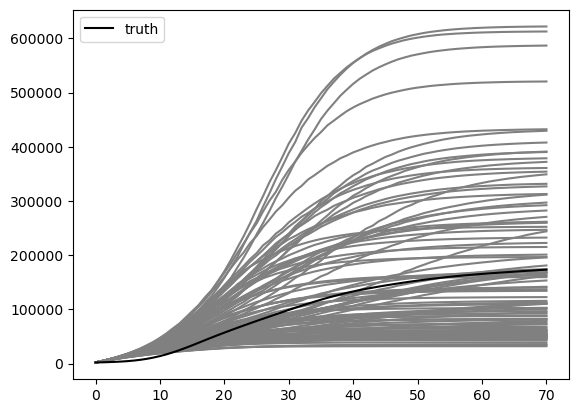

In [6]:
import multiprocessing
%matplotlib inline
y_truth=np.asarray(casedata.data['cases_all_germany_ma7'].Confirmed)[:71]

plt.plot(y_truth, "k", zorder=1, label="truth")
n_samples = 100
params = prior.sample((n_samples,))

with multiprocessing.Pool() as pool:
    y_=[result for result in pool.map(simulator2, params)]

y_=torch.stack(y_)
y_=np.asarray(y_)

plt.plot(y_.T, "grey", zorder=0)
plt.legend()
plt.show()

## Running the simulations

This step is standard for the flexible interface, we have seen it previously when working with text message example.

In [7]:
from sbi.inference import SNPE, simulate_for_sbi

theta,x=simulate_for_sbi(simulator2,prior,10000,num_workers=24)


Running 10000 simulations in 10000 batches.: 100%|██████████| 10000/10000 [06:33<00:00, 25.44it/s]


## Summary statistic

Now let us talk about summary statistic. Previously we have been extracting summary statistic from the simulation data without taking into the account the actual datapoint. However, this is clearly not forbidden!

Below we define a summary statistic which computes the mean squared error between the simulation output and the ground truth.

Note, that this kind of strategy can certainly work if you believe that all your datapoint correspond to a model with the same parameter values. However, if you want to run the SBI inference with the same prior on multiple datapoints, each one with possibly different parameter values, this approach may not work.

In [8]:
x=x.reshape((10000,71))

y_truth=np.asarray(casedata.data['cases_all_germany_ma7'].Confirmed)[:71]

def get_MSE_sim(x,y_t):
    x=np.asarray(x)
    y_t=y_t.reshape((1,y_t.shape[0]))
    return np.mean(np.square(x - y_t),axis=1,keepdims=True)

x1=get_MSE_sim(x,y_truth)

## Specifying and training the model

Here we define the model (SNPE in our case) and train the neural network

In [9]:
x1=np.float32(x1)
x1=torch.from_numpy(x1)

inference=SNPE(prior)

_ = inference.append_simulations(theta, x1).train()

posterior = inference.build_posterior()


 Neural network successfully converged after 135 epochs.

## Incorporating the datapoint and visualising the results

Since we have already specified our datapoint when computing the summary statistic, in order to run the inference on the same data point we pass the variable `y_truth` as 0. We sample from the posterior and visualise the distributions of our parameters.

Drawing 10000 posterior samples: 11294it [00:01, 6412.12it/s]                          


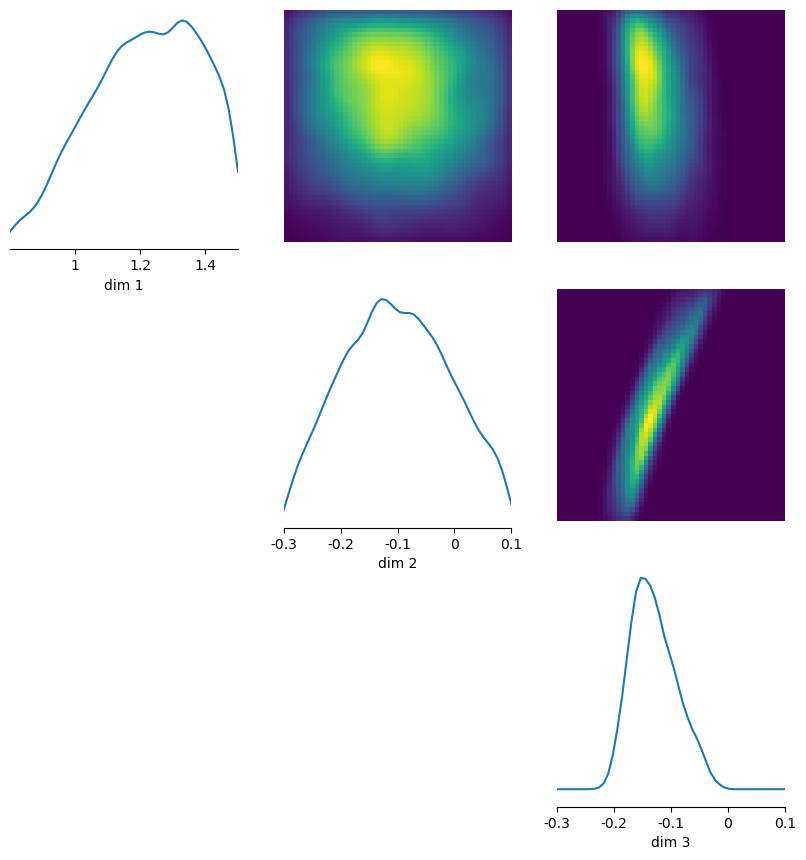

In [10]:
%matplotlib inline

y_truth= torch.as_tensor(
    [
        [
            0.0,
        ]
    ]
)



theta_p = posterior.sample((10000,), x=y_truth)

fig, out = pairplot(theta_p, limits=[[0.8,1.5],[-0.3,0.1],[-0.3,0.1]], fig_size=(3,3), upper='kde', diag='kde')

## What would happen if we did not use the summary statistic?

Indeed, let us take a look. We define a new inference object `inference1` and instead of the summary statistic `x1` we pass the raw simulator outputs `x` to the neural network. Note that the datapoint we are using for the posterior sampler is the actual RKI data, not 0 tensor.

 Neural network successfully converged after 543 epochs.

Drawing 10000 posterior samples: 11094it [00:01, 6703.05it/s]                          


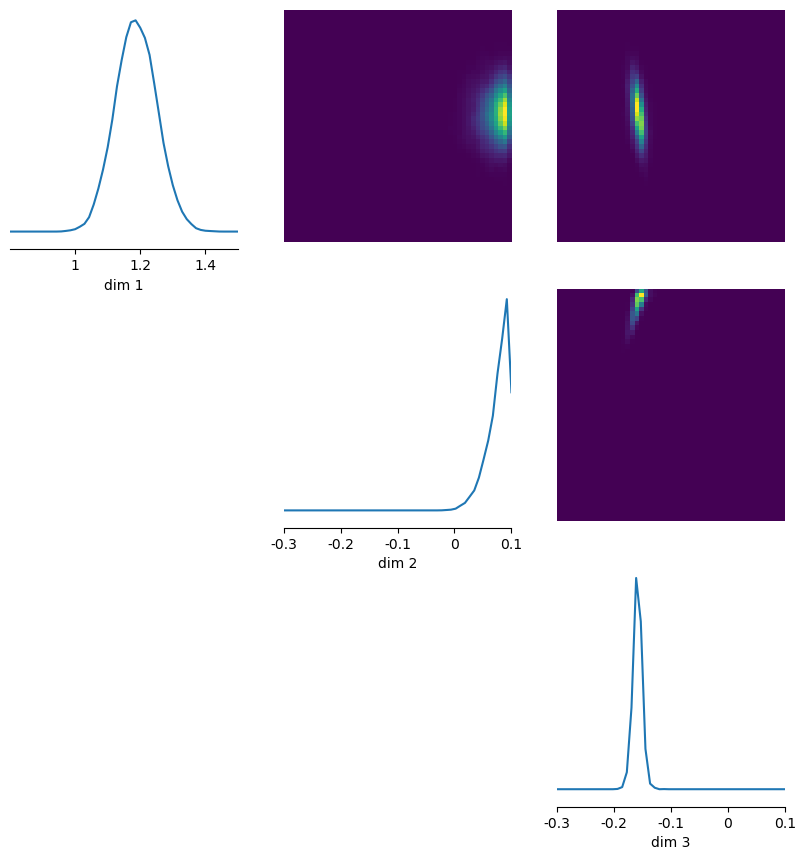

In [11]:
inference1 = SNPE(prior)
x=np.float32(x)
x=torch.from_numpy(x)

_ = inference1.append_simulations(theta, x).train(training_batch_size=1000)
    
posterior1 = inference1.build_posterior()

y_o=np.asarray(casedata.data['cases_all_germany_ma7'].Confirmed)[:71]
y_o=torch.from_numpy(y_o)

theta_p1 = posterior1.sample((10000,), x=y_o)


fig1, out1 = pairplot(theta_p1.detach().cpu().numpy(), limits=[[0.8,1.5],[-0.3,0.1],[-0.3,0.1]], fig_size=(3,3), upper='kde', diag='kde')


## Comparing the results

Let us now do a simple sanity check. We take the mean of the posterior parameter samples corresponding to each one of the models (with MSE and without MSE), simulate a data trajectory according to each one of them, and compare the to the RKI data.

Clearly the trajectory with summary statistic looks better. You can increase the numer of simulations and see whether this will improve the inference in any one of the cases.

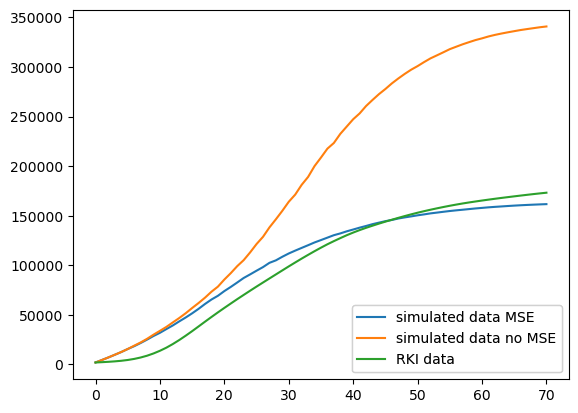

In [12]:
observation1=simulator2(torch.unsqueeze(torch.mean(theta_p1.detach().cpu(),axis=0),0))

observation=simulator2(torch.unsqueeze(torch.mean(theta_p,axis=0),0))

fig,ax=plt.subplots()

line1,=ax.plot(observation,label="simulated data MSE")
line2,=ax.plot(observation1,label="simulated data no MSE")
line3,=ax.plot(casedata.data['cases_all_germany_ma7'].Confirmed[0:71],label="RKI data")
first_legend = ax.legend(handles=[line1,line2,line3], loc='lower right')
ax.add_artist(first_legend)
plt.show()

